###   1. Hypothesis: We can derive an indication of AADT for local government roads from the Sample value in                      HERE historical data
-	Due by 6 November
-	New Austroads Guide to Temporary Traffic Management have a criteria to categorise state and local roads
-	Indication of AADT for local government roads (let’s say bands by 1000s) is desirable
-	Can the sample value in HERE historical data give us an indication of AADT?
-	Suggested approach/PoC – try to derive values from HERE by using a known AADT dataset

### Reliability of HERE - probe data.

The data as provided by HERE is a sample selection - how reflective is this of the overall populations distribution? 

1) Variance
- Is the variation in here refelective of seansonal,daily and hourly trends?

2) Bias
- Is the sample sample selected have systematic bias?
- Are there  privacy and applied aggregated data?

3) Sample Statistics
- what are the error when we scale HERE sample if using aadt from loops are used? 

Approachs
- 1)Compare a High Count sites & a low Count sites then the sites below the median.
- 2) Autotmate approach to deliver analyisis against all sites.

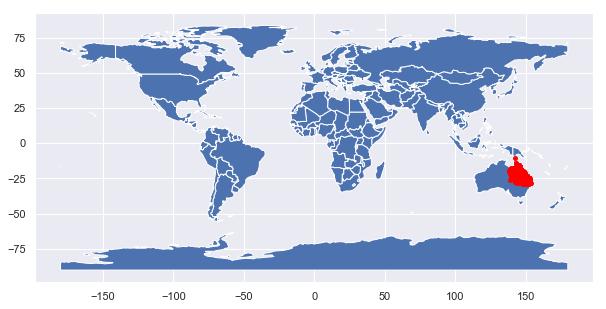

In [1280]:
#### Load AADT 2018 data from Open data

import pandas as pd 
#Annual Average Daily Traffic (AADT) is the number of vehicles passing a point on a road in a 24 hour period averaged over a calendar year. This figure for short term counts is seasonally adjusted.
aadt_2018=pd.read_csv('trafficcensus2018.csv') #load from https://www.data.qld.gov.au/dataset/traffic-census-for-the-queensland-state-declared-road-network/resource/4b1011ec-61f1-4818-b44c-edfe15828a4e
aadt_2018.head()
aadt_2018.set_index('SITE_ID') 

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
geometry = [Point(xy) for xy in zip(aadt_2018['LONGITUDE'],aadt_2018['LATITUDE'])]
aadt_2018_gdf = GeoDataFrame(aadt_2018, geometry=geometry)
aadt_2018_gdf.set_index('SITE_ID') 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aadt_2018_gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Text(0, 0.5, 'Frequency')

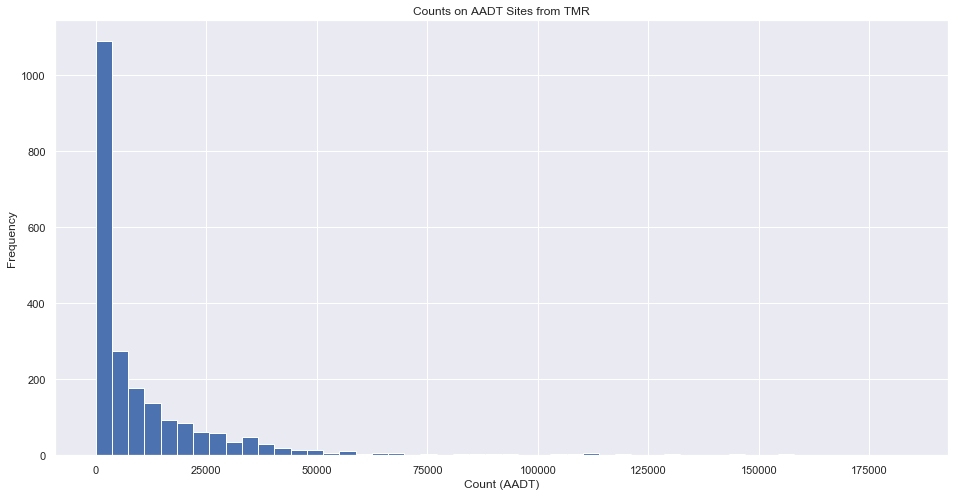

In [1416]:
aadt_2018_gdf.hist('AADT', bins= 50)
plt.title('Counts on AADT Sites from TMR')
plt.xlabel('Count (AADT)')
plt.ylabel('Frequency')

## Variance

##### Check minimum criteria. A sites with high aadt count.
Site 135970 on Pine River Bridge - with a count of 77,905 aadt.

HERE route link selected historic 2018/01/01 - 2018/12/31 to match with addt site.

In [1417]:
#Sort top aadt counts
aadt_2018_gdf_sort= aadt_2018_gdf.sort_values(by='AADT', ascending=False)
#aadt_2018_gdf_sort[0:10]
site_selected = aadt_2018_gdf_sort[3:4] # Site 135970 on Pine River Bridge selected as candidate

#Display location
lons= site_selected['LONGITUDE'].values.tolist()
lats= site_selected['LATITUDE'].values.tolist()
fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.', markersize = 30)
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Text(0, 0.5, 'Frequency')

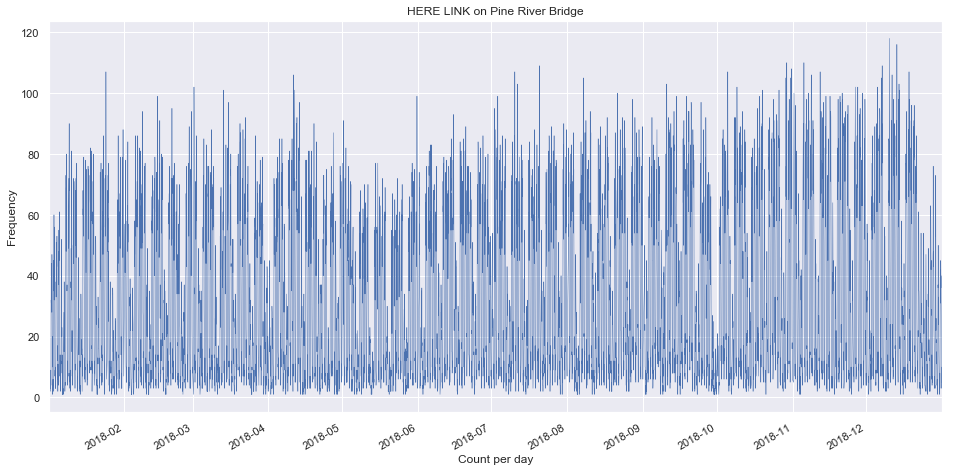

In [1420]:
#load HERE sample for link at Site 135970
here_links=pd.read_csv('HERE_DA_40074_00000.csv') 
#here_links.head() #show the format data

#assign weekday to dataset
here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date/time column as time type
#here_links_rel_col=here_links_rel_col.set_index('DATE-TIME')

#set weekday names
here_links_rel_col['DATE-TIME'] = pd.to_datetime(here_links_rel_col['DATE-TIME'])
here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name()
#here_links_rel_col.dtypes

#show timeseries
here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 8)})
here_links_rel_col_timeseries['COUNT'].plot(linewidth=0.5);
plt.title('HERE LINK on Pine River Bridge')
plt.xlabel('Count per day')
plt.ylabel('Frequency')

#### Above timeseries show nonstationarity, periodic fluctuations.
Lets investigate day variation and distribution. 

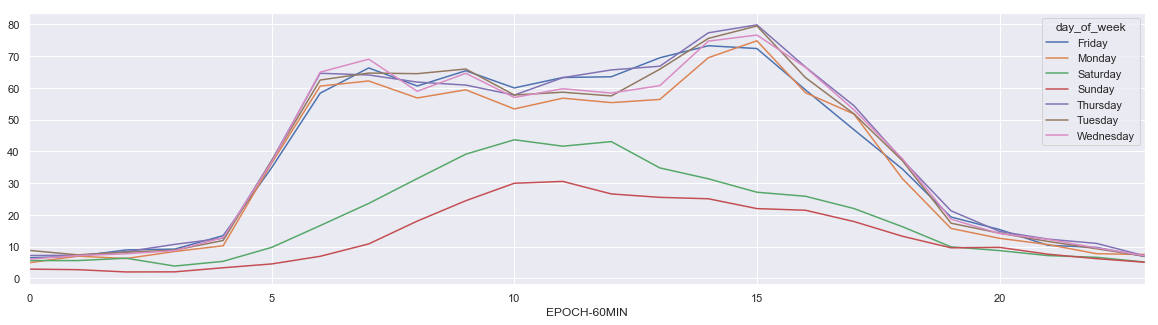

In [1421]:
#average day of week
here_links_rel_col.pivot_table(
    index = 'EPOCH-60MIN',
    columns ='day_of_week',
    values = 'COUNT',   aggfunc='mean', fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);

Expected typical distribution. Weekend does not follow bimodal, show maximum pentration rate at 10am -12pm.
Remove weekends and investigate only weekdays ast typical days. 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


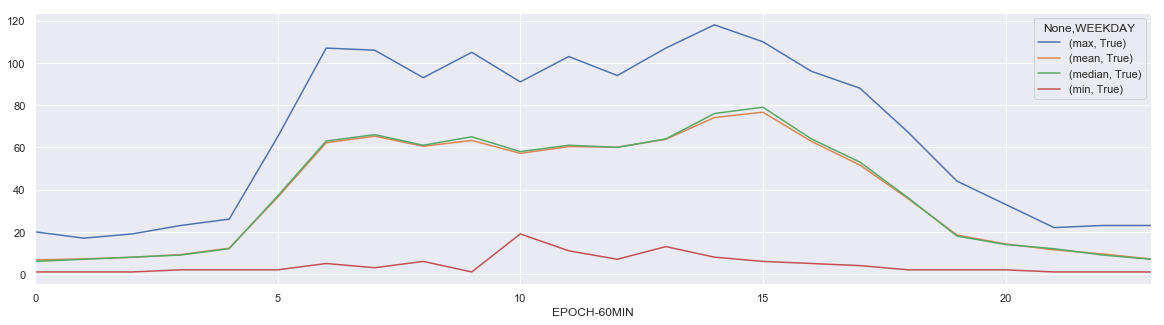

In [1425]:
# just weekdays statistics
here_links_rel_col['WEEKDAY']= ~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
mask=~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
here_links_rel_col_weekdays = here_links_rel_col.loc[mask] #just weekdays

here_links_rel_col_weekdays.pivot_table(
    index = 'EPOCH-60MIN',
    columns ='WEEKDAY',
    values = 'COUNT',   aggfunc=('max','median','mean','min'), fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);

### Law of large numbers theorm 
'average of results should reflect expected value when n(number of expirements) increase'

Shows variation in weekday. Low counts do not reflect what we expect to see.
However the median/average is representative and is a promising. Averaging large n removes outliers.

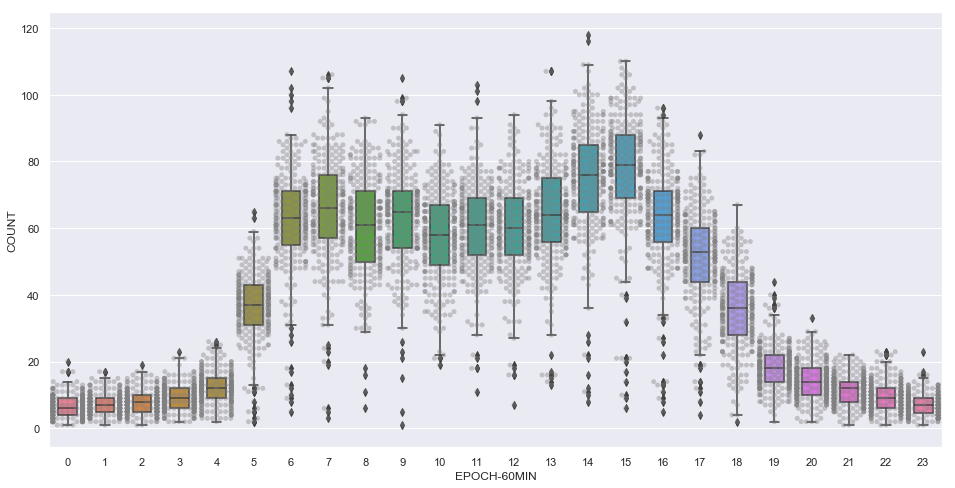

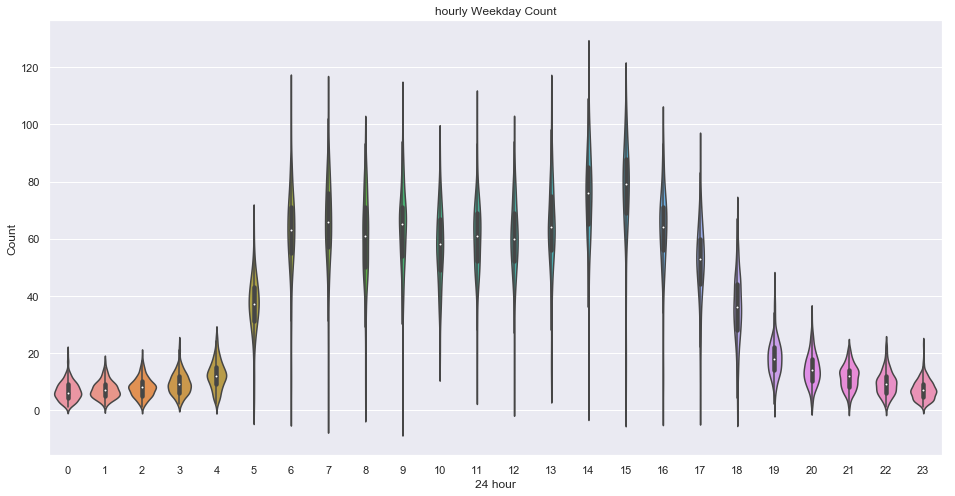

In [1325]:
#shows distribution on weekday count
bplot=sns.boxplot(y='COUNT', x='EPOCH-60MIN', 
                 data=here_links_rel_col_weekdays, 
                 width=0.5,
                 palette="husl")

# add swarmplot
bplot=sns.swarmplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              color='grey',
              alpha=0.4)

# add violin plot
fig, axes = plt.subplots()
sns.violinplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              alpha=0.4)
axes.set_title('hourly Weekday Count')
axes.set_xlabel('24 hour')
axes.set_ylabel('Count')

plt.show()

Distribution by hour - shows the large variance hours 5am - 6pm.

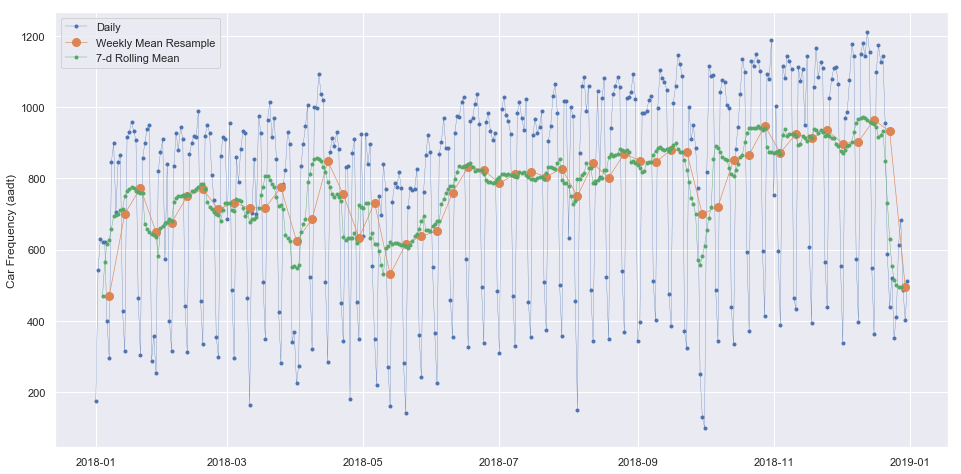

In [1520]:
#daily
here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index

#sum to day
here_links_rel_col_timeseries_daily = here_links_rel_col_timeseries['COUNT'].resample('D').sum()

#resample to week
here_links_rel_col_timeseries_weekly = here_links_rel_col_timeseries_daily.resample('W').mean()

#Trends
#opsd_365d = here_links_rel_col_timeseries_daily.rolling(window=365, center=True, min_periods=365).mean()
opsd_7d = here_links_rel_col_timeseries_daily.rolling(7, center=True).mean()

start, end = '2018-01', '2018-12'
fig, ax = plt.subplots()
ax.plot(here_links_rel_col_timeseries_daily.loc[start:end],
        marker='.', linestyle='-', linewidth=0.3, label='Daily')
ax.plot(here_links_rel_col_timeseries_weekly.loc[start:end],
        marker='o', markersize=8, linewidth=0.6, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d ,marker='.', linestyle='-', linewidth=0.4,label='7-d Rolling Mean')
label='Trend (365-d Rolling Mean)'

ax.set_ylabel('Car Frequency (aadt)')
ax.legend();    


### Trends
We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling. 

We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

Note: peaks reflective of public holidays.

Results
Here weekday aadt: 923
Here vs aadt: 1.2 %


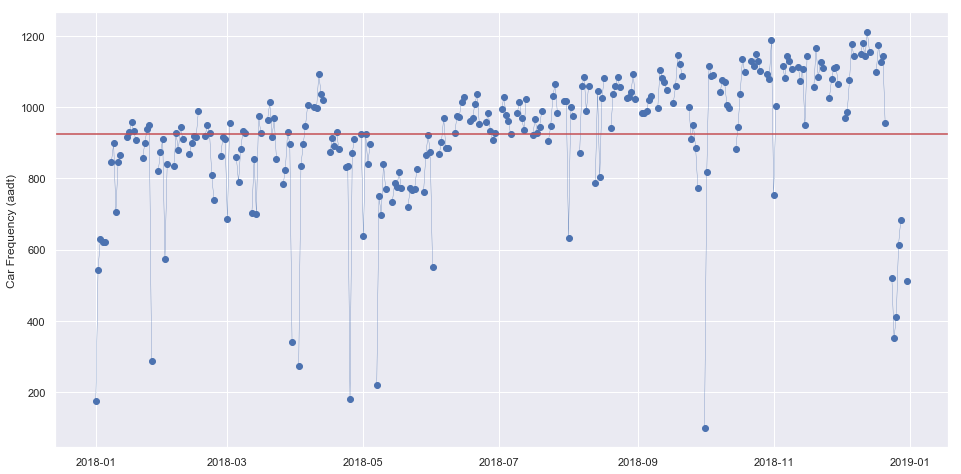

In [1541]:
#Remove the above weekends
here_links_rel_col_weekdays_timeseries = here_links_rel_col_weekdays.set_index('DATE-TIME') #set index
here_weekday_sum = here_links_rel_col_weekdays_timeseries['COUNT'].resample('D').sum()
here_weekday_sum =here_weekday_sum.replace(0, np.NaN)

#aadt
here_weekday_aadt = int(here_weekday_sum.mean()) 
here_weekday_aadt

fig, ax = plt.subplots()
ax.plot(here_weekday_sum,
        marker='o', linestyle='-', linewidth=0.3, label='Weekdays')
ax.axhline(y=here_weekday_aadt, color='r', linestyle='-')
ax.set_ylabel('Car Frequency (aadt)')

# Derived aadt 
#Compare against actuals
aadt_loops = 77905  # aadtSegmentAnalysisReportSummarys-7467981069708955029.pdf
print ('Results')
print('Here weekday aadt: ' +str(here_weekday_aadt))
print('Here vs aadt: '+str(round(here_weekday_aadt/aadt_loops *100,1)) + ' %')

### Variance

#### Given a understading of a site with large count, lets investigate a extremely small count site.
Site 120779 - MIVA ROAD	 with aadt of 24.

In [1361]:
aadt_2018_gdf_sort= aadt_2018_gdf.sort_values(by='AADT', ascending=True) #sort lowest aadt values
lowestlimit = 30

# Size limitation displaying over 1000 points
lons= lowest_aadt_2018_gdf_sort['LONGITUDE'][0:lowestlimit].values.tolist()
lats= lowest_aadt_2018_gdf_sort['LATITUDE'][0:lowestlimit].values.tolist()

site_selected =aadt_2018_gdf_sort[19:20] #this site is selected 
lons= site_selected['LONGITUDE'].values.tolist()
lats= site_selected['LATITUDE'].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.', markersize = 30)
#And after this call the funtion:
mplleaflet.display(fig=fig,)
#site_selected

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


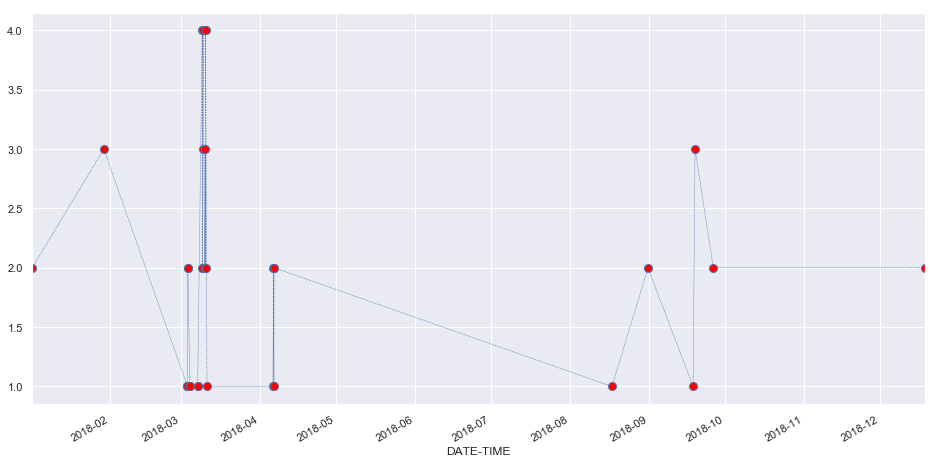

In [1545]:
#load here link
here_links=pd.read_csv('HERE_DA_40137_00000.csv') 
here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date/time column as time type

#set weekday names
here_links_rel_col['DATE-TIME'] = pd.to_datetime(here_links_rel_col['DATE-TIME'])
here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name()
#here_links_rel_col.tail()

#show timeseries
here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 8)})
here_links_rel_col_timeseries['COUNT'].plot(linewidth=0.5,marker='o',linestyle='dashed',label="toto",markersize=8,markerfacecolor='red');

### Resample - upsampling ( irregularity spaced time series)

It is often useful to resample our time series data to a lower or higher frequency. Resampling to a lower frequency (downsampling, as shown previously) usually involves an aggregation operation — for example, computing monthly count totals from daily data - for large couting sites.

This site (low count) requires resampling to a higher frequency (upsampling) is less common and often involves interpolation or other data filling method — for example, interpolating hourly count data to 10 minute intervals for input to a scientific model.
*note: Future works, for irregular spaced time series explore constructing a Kalman filter.

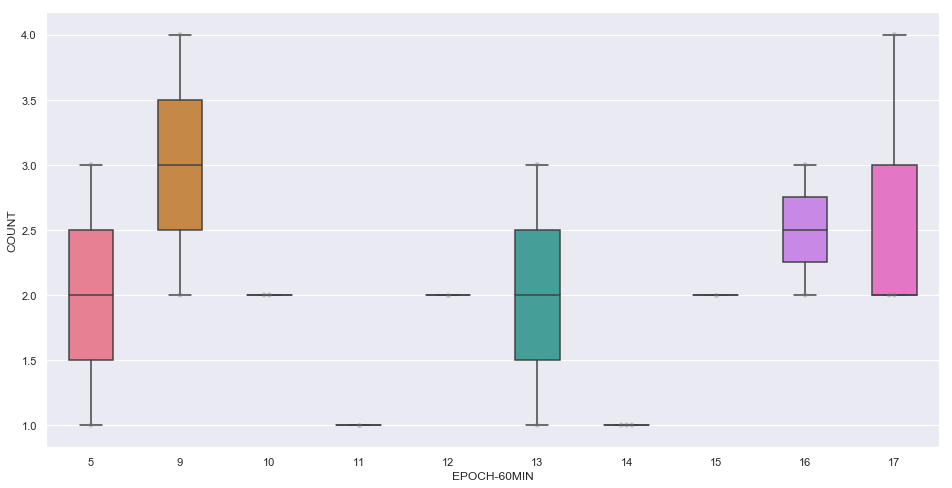

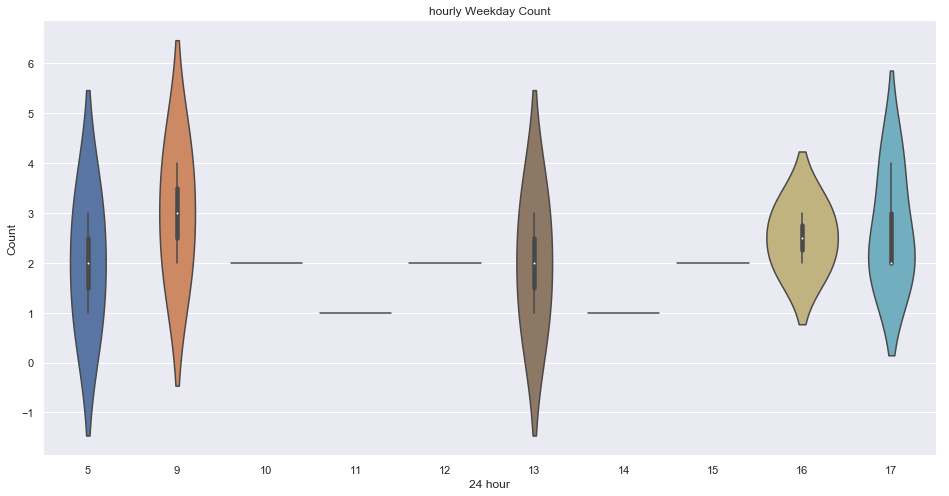

In [1548]:
#lets have a look at the breakdown by weekdays hours.
# just weekdays statistics
here_links_rel_col['WEEKDAY']= ~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
mask=~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
here_links_rel_col_weekdays = here_links_rel_col.loc[mask] #just weekdays

#shows distribution on weekday count
bplot=sns.boxplot(y='COUNT', x='EPOCH-60MIN', 
                 data=here_links_rel_col_weekdays, 
                 width=0.5,
                 palette="husl")

# add swarmplot
bplot=sns.swarmplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              color='grey',
              alpha=0.4)

# add violin plot
fig, axes = plt.subplots()
sns.violinplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              alpha=0.4)
axes.set_title('hourly Weekday Count')
axes.set_xlabel('24 hour')
axes.set_ylabel('Count')

plt.show()


In [1377]:
# shows most samples are collected at 5am,9am,1pm,4pm,5pm
here_links_rel_col_weekdays_by_hour_avg_statistic =here_links_rel_col_weekdays.groupby(['EPOCH-60MIN'])['DATE-TIME','COUNT'].mean()
here_links_rel_col_weekdays_by_hour_avg_statistic

,COUNT
EPOCH-60MIN,
5,2.000000
9,3.000000
10,2.000000
11,1.000000
12,2.000000
13,2.000000
14,1.000000
15,2.000000
16,2.500000


In [1560]:
#Calculate the average weekday count - derived weekday
aadt_here_link=int(round(here_links_rel_col_weekdays_by_hour_avg_statistic.sum(),-1)) #nearest car
aadt_here_link =here_links_rel_col_weekdays_by_hour_avg_statistic.mean()/365
aadt_here_link= round(aadt_here_link['COUNT'],2)

#Compare against actuals
aadt_loops = 24  # aadtSegmentAnalysisReportSummarys-7467981069708955029.pdf
#print(str(round(aadt_here_link/aadt_loops *100,1)) + ' %')

print ('Results')
print('Here aadt: ' +str(aadt_here_link))
print('Here vs aadt: '+str(round(aadt_here_link/aadt_loops *100,3)) + ' %')

Results
Here aadt: 0.01
Here vs aadt: 0.042 %


#### As this is not there is not enough data - unable to make a provide confident sample statistics. 

### Scaling ability  Investiagation on a number of sites.
For scalabity any link with zero count will be not included.
####  Bias and Variance

In [1561]:
#resample to aadt values to compare against actuals
def aadt_here_links_statistics(here_file_name):
    '''Takes a here link and calcuates statistical values for aadt'''
    
    #laod file
    here_links =pd.read_csv(here_file_name)
    
    #add features - featurs by irregulary spaced
    here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
    here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date time column
    here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name() #set day of week

    #sum up to the day - equally spaced.
    df_temp = here_links_rel_col[['COUNT','DATE-TIME']]
    df_temp['DATE-TIME'] =  pd.to_datetime(df_temp['DATE-TIME'])
    df_temp.index = df_temp['DATE-TIME']
    df_resample_day =  df_temp.resample('D').sum()
    average_day_mean = int(round(df_resample_day.mean(),-1))
    average_day_mean

    #sum up to the weekdays - equally spaced.
    here_links_rel_col['WEEKDAY']= ~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
    mask=~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
    here_links_rel_col_weekdays = here_links_rel_col.loc[mask] #just weekdays
    here_links_rel_col_weekdays

    df_temp = here_links_rel_col_weekdays[['COUNT','DATE-TIME']]
    df_temp['DATE-TIME'] =  pd.to_datetime(df_temp['DATE-TIME'])
    df_temp.index = df_temp['DATE-TIME']
    df_resample_day =  df_temp.resample('D').sum()
    df_resample_day =  df_resample_day.replace(0, np.NaN) # so mean is not included in calculations
    average_weekday_mean = int(round(df_resample_day.mean(),-1))
    average_weekday_max = int(round(df_resample_day.max(),-1))
    average_weekday_min = int(round(df_resample_day.min(),-1))
    average_weekday_median = int(round(df_resample_day.median(),-1))
    
    return average_weekday_mean, average_weekday_max, average_weekday_min,average_weekday_median

In [1563]:
#load datasets
list_of_files = ('HERE_DA_40074_00000.csv','HERE_DA_40137_00000.csv','HERE_DA_40222_00000.csv','HERE_DA_40215_00000.csv',
                 'HERE_DA_40218_00000.csv','HERE_DA_40219_00000.csv','HERE_DA_40221_00000.csv','HERE_DA_40274_00000.csv',
                 'HERE_DA_40272_00000.csv','HERE_DA_40271_00000.csv','HERE_DA_40270_00000.csv')


site_id_ordered = ['135970','120779','55452','30014','32554','20017','55430','135725','135687','135714','136335']
site_aadt_ordered = [155916,24,2019,1533,1309,7441,4802,21610,31308,28321,8122]

#TO add
# Link        Site   aadt

results_data = pd.DataFrame([])
i=0
for link in list_of_files:
    ink_mean,link_max,link_min,link_med =  aadt_here_links_statistics(link)
    results_data = results_data.append(pd.DataFrame({'site': int(site_id_ordered[i]),'aadt_actual': site_aadt_ordered[i],'aadt_mean_here': ink_mean,  'aadt_max_here': link_max, 'aadt_min_here': link_min, 'aadt_median_here':link_med,'sample_percentage': round((ink_mean/site_aadt_ordered[i])*100,1)}, index=[i]), ignore_index=True)
    i+=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,site,aadt_actual,aadt_mean_here,aadt_max_here,aadt_min_here,aadt_median_here,sample_percentage
0,135970,155916,920,1210,100,950,0.6
1,120779,24,0,10,0,0,0.0
2,55452,2019,10,20,0,10,0.5
3,30014,1533,0,20,0,0,0.0
4,32554,1309,10,40,0,10,0.8
5,20017,7441,0,10,0,0,0.0
6,55430,4802,10,20,0,0,0.2
7,135725,21610,80,110,0,80,0.4
8,135687,31308,120,200,10,130,0.4
9,135714,28321,80,140,10,80,0.3


In [1564]:
results_data

,site,aadt_actual,aadt_mean_here,aadt_max_here,aadt_min_here,aadt_median_here,sample_percentage
0,135970,155916,920,1210,100,950,0.6
1,120779,24,0,10,0,0,0.0
2,55452,2019,10,20,0,10,0.5
3,30014,1533,0,20,0,0,0.0
4,32554,1309,10,40,0,10,0.8
5,20017,7441,0,10,0,0,0.0
6,55430,4802,10,20,0,0,0.2
7,135725,21610,80,110,0,80,0.4
8,135687,31308,120,200,10,130,0.4
9,135714,28321,80,140,10,80,0.3


#### *Note Site: 20017 (Gympie) has a compartively large aadt of 7441 and here link return little no average value and Site: 136335 (Brisbane City) has the inverse relationship.

In [1384]:
site_qaqc = aadt_2018.loc[aadt_2018['SITE_ID'] == 136335]
lons= site_qaqc['LONGITUDE'].values.tolist()
lats= site_qaqc['LATITUDE'].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.')
#And after this call the funtion:
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [1268]:
## Remove addt_here values that come back as zero - can not use these
results_data_nozeros = results_data[~(results_data['aadt_mean_here'] == 0)]
#Rank
results_data_nozeros['actual_rank'] = results_data_nozeros['aadt_actual'].rank(ascending=False).astype(int)
results_data_nozeros['here_rank'] = results_data_nozeros['aadt_mean_here'].rank(ascending=False).astype(int)
results_data_nozeros

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,site,aadt_actual,aadt_mean_here,aadt_max_here,aadt_min_here,aadt_median_here,sample_percentage,actual_rank,here_rank
0,135970,155916,920,1210,100,950,0.6,1,1
2,55452,2019,10,20,0,10,0.5,7,7
4,32554,1309,10,40,0,10,0.8,8,7
6,55430,4802,10,20,0,0,0.2,6,7
7,135725,21610,80,110,0,80,0.4,4,4
8,135687,31308,120,200,10,130,0.4,2,3
9,135714,28321,80,140,10,80,0.3,3,4
10,136335,8122,130,200,10,140,1.6,5,2


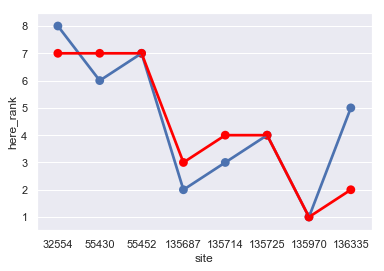

In [1269]:
import seaborn as sns
sns.set(style="darkgrid")
#tips = sns.load_dataset("tips")
#ax = sns.pointplot(x="time", y="total_bill", data=tips)

#tips = sns.load_dataset(results_data)
ax = sns.pointplot(x='site', y='actual_rank', data=results_data_nozeros)
ax = sns.pointplot(x='site', y='here_rank',  color='red', data=results_data_nozeros)

### Conclusion:
Non linear relationship between aadt sites from TMR and HERE samples (penetration rates ranges from 0 - 1.6%).

From this initial investigation large n sample links (law of large numbers) indicate a distribution that what we would expect to see. Further investigation maybe required to how similar this is to actuals. If this is the case - metrics such as speed/time maybe inferred with confidence.

However aadt values - scalabilty give a constant(x) are not practical given the non linear relationship between Aadt and HERE. Futher bias and variance are show in both large and small counts.

1) Recommend further studies into the relationship between type and vehicles and road (i.e Similar count two links - One with a approved route for hwy and one restricted).

2) Automation to extract all links and process. 
Started code and found 1) links change and will not always get a result. 2) Likely to see similar results as presented.

3) Further analysis by hour break down with aadt.

#### View Site lcoations

In [1386]:
site_id_ordered = ['135970','120779','55452','30014','32554','20017','55430','135725','135687','135714','136335']# make sure this matches
results=df[df['SITE_ID'].isin(site_id_ordered)]

lons= results['LONGITUDE'].values.tolist()
lats= results['LATITUDE'].values.tolist()
fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.',marker='o',markersize=10)
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Sort and rank - Bias

In [1090]:
results_data['actual_rank'] = results_data['aadt_actual'].rank(ascending=False).astype(int)
results_data['here_rank'] = results_data['aadt_mean_here'].rank(ascending=False).astype(int)

In [860]:
#boxplot = aadt_2018.boxplot(column='AADT')
aadt_2018_gdf_sort= aadt_2018_gdf.sort_values(by='AADT', ascending=False)
#selecting out the lower AADT sites - 50%-25%
round(aadt_2018['AADT'].describe(),0)

count      2218.0
mean      11731.0
std       20398.0
min           0.0
25%         772.0
50%        3840.0
75%       14179.0
max      183592.0
Name: AADT, dtype: float64

In [1124]:
aadt_25_to_50 = aadt_2018.loc[(aadt_2018['AADT'] > 772) & (aadt_2018['AADT'] < 3840)] 
aadt_50_higher = aadt_2018.loc[(aadt_2018['AADT'] > 3840)] 

In [1185]:
aadt_50_higher

,SITE_ID,DESCRIPTION,LONGITUDE,LATITUDE,AADT,TDIST,PERCENT_HV,RSECT_ID,ROAD_NAME,TDIST_START,TDIST_END,geometry
2,11412,80m south of Hillside Dve,153.233820,-27.732727,12134,0.500,22.26,1003,STAPYLTON - JACOBS WELL ROAD,0.000,1.090,POINT (153.2338199 -27.73272664)
3,12966,400m west of Quinns Rd,153.241597,-27.727702,8218,1.450,20.86,1003,STAPYLTON - JACOBS WELL ROAD,1.090,1.860,POINT (153.2415967 -27.72770231)
4,11754,600m east of Alberton Road,153.265828,-27.720495,4467,4.150,15.88,1003,STAPYLTON - JACOBS WELL ROAD,1.860,7.950,POINT (153.2658279 -27.72049471)
6,11548,Between Norman St & Scarborough St,153.410776,-27.961066,18753,0.150,8.88,101,SMITH STREET CONNECTION,0.000,0.480,POINT (153.4107765 -27.96106645)
7,11400,Between Kumbari Av & Parklands Dv,153.389276,-27.962996,51028,2.390,4.83,101,SMITH STREET CONNECTION,0.480,3.740,POINT (153.3892765 -27.9629959)
8,11545,1.5km west of Labrador-Carrara Rd Opass,153.361826,-27.962901,68524,5.200,3.27,101,SMITH STREET CONNECTION,3.740,7.400,POINT (153.3618256 -27.96290083)
9,11403,Between Sunlight Dr & Billabong Pl,153.436673,-28.101401,28192,2.200,5.63,102,BURLEIGH CONNECTION ROAD,0.000,3.300,POINT (153.4366728 -28.10140129)
10,10890,630m west of Mattocks Rd,153.412752,-28.101317,34886,4.570,9.24,102,BURLEIGH CONNECTION ROAD,3.300,5.690,POINT (153.4127519 -28.10131688)
11,11549,280m north of Nerang St,153.409425,-27.967359,23002,0.550,4.30,103,SOUTHPORT - BURLEIGH ROAD,0.000,1.140,POINT (153.4094246 -27.96735885)
12,10009,Between Harvest Cl & Brolga Av,153.410884,-27.979563,34058,1.940,3.87,103,SOUTHPORT - BURLEIGH ROAD,1.140,3.969,POINT (153.4108836 -27.97956318)


In [1127]:
## Size limitation displaying over 1000 points

lons= aadt_50_higher['LONGITUDE'][1:10].values.tolist()
lats= aadt_50_higher['LATITUDE'][1:10].values.tolist()

#lons= aadt_25_to_50['LONGITUDE'].values.tolist()
#lats= aadt_25_to_50['LATITUDE'].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.')

#And after this call the funtion:
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [1199]:
aadt_newEngland = aadt_2018.loc[aadt_2018['ROAD_NAME'] == 'ALBANY CREEK SUB-ARTERIAL ROAD'] 
#aadt_newEngland = aadt_2018.loc[aadt_2018['SITE_ID'] == 40529]

In [1200]:
aadt_newEngland

,SITE_ID,DESCRIPTION,LONGITUDE,LATITUDE,AADT,TDIST,PERCENT_HV,RSECT_ID,ROAD_NAME,TDIST_START,TDIST_END,geometry
2204,136083,U94 Albany Ck Rd PedXing @RetirementVill,153.011811,-27.363358,22223,0.542,2.93,U94,ALBANY CREEK SUB-ARTERIAL ROAD,0.00,1.35,POINT (153.0118106 -27.36335843)
2205,135725,West of Trouts Rd,153.003031,-27.359807,21610,1.500,5.23,U94,ALBANY CREEK SUB-ARTERIAL ROAD,1.35,4.27,POINT (153.0030313 -27.3598069)


In [1201]:
lons= aadt_newEngland['LONGITUDE'][2:3].values.tolist()
lats= aadt_newEngland['LATITUDE'][2:3].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.')

#And after this call the funtion:
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [1202]:
aadt_newEngland[1:2]

,SITE_ID,DESCRIPTION,LONGITUDE,LATITUDE,AADT,TDIST,PERCENT_HV,RSECT_ID,ROAD_NAME,TDIST_START,TDIST_END,geometry
2205,135725,West of Trouts Rd,153.003031,-27.359807,21610,1.5,5.23,U94,ALBANY CREEK SUB-ARTERIAL ROAD,1.35,4.27,POINT (153.0030313 -27.3598069)


In [1203]:
#Set session proxies
import requests
import time
import json


session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}

#TO:DO fix this up....
loc_lat=aadt_2018_gdf_sort[19:20]['LATITUDE']
loc_long=aadt_2018_gdf_sort[19:20]['LONGITUDE']

#hard coded
loc_lat=-27.359807
loc_long=153.003031
prox='10'

location=str(loc_lat)+','+str(loc_long)

#url +="&mode=retrieveAddresses&maxresults=1&additionaldata=IncludeShapeLevel%2CpostalCode" #if you want the areas searched
url +="&mode=retrieveAddresses&maxresults=1"
url +="&locationattributes=mapReference"
url +="&prox="+location+','+prox
response = session.get(url)

#creditials load
data=pd.read_json("credentials.json")
app_id=data['credentials'][0]['appid']
app_code=data['credentials'][0]['appcode']
            
url = "https://reverse.geocoder.api.here.com/6.2/reversegeocode.json"
url +="?app_id="+app_id+"&app_code="+app_code
#url +="&mode=retrieveAddresses&maxresults=1&additionaldata=IncludeShapeLevel%2CpostalCode" #if you want the areas searched
url +="&mode=retrieveAddresses&maxresults=1"
url +="&locationattributes=mapReference"
url +="&prox="+location+','+prox

response = session.get(url)
response_json = response.json()

here_link=response_json['Response']['View'][0]['Result'][0]['Location']['MapReference']['ReferenceId'] #PVids
here_link_street=response_json['Response']['View'][0]['Result'][0]['Location']['Address']['Street'] # name 3
pvid_x=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
pvid_y=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']

In [1204]:
here_link

'1202609889'

In [923]:
here_link_street

'Grey St'

#### Using HERE API for link reference
Found link reference does not always match - as historic 01/2018-12/2018

(TODO: Need to write automated api call here --- currently sending request via GUI,revisit)

### Below code for automating identification PVids from HERE
Return HERE PVIDS
prox=lat,lon,radius .../6.2/reversegeocode.{format}?=...
https://reverse.geocoder.api.here.com/6.2/reversegeocode.{format} https://developer.here.com/documentation/geocoder/topics/resources.html

In [1287]:
#Set session proxies
import requests
import time
import json

session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}
#session.get('https://www.tmr.qld.gov.au')

#location='-27.294103,153.018231' #AADT site counter, this needs to be parsed
loc_lat=-27.294103#   -27.732727
loc_long=153.018231#   153.233820

location=str(loc_lat)+','+str(loc_long)
prox='10'

#creditials load
data=pd.read_json("credentials.json")
app_id=data['credentials'][0]['appid']
app_code=data['credentials'][0]['appcode']
            
url = "https://reverse.geocoder.api.here.com/6.2/reversegeocode.json"
url +="?app_id="+app_id+"&app_code="+app_code
#url +="&mode=retrieveAddresses&maxresults=1&additionaldata=IncludeShapeLevel%2CpostalCode" #if you want the areas searched
url +="&mode=retrieveAddresses&maxresults=1"
url +="&locationattributes=mapReference"
url +="&prox="+location+','+prox

response = session.get(url)
response_json = response.json()

here_link=response_json['Response']['View'][0]['Result'][0]['Location']['MapReference']['ReferenceId'] #PVids
here_link_street=response_json['Response']['View'][0]['Result'][0]['Location']['Address']['Street'] # name 3
pvid_x=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
pvid_y=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']

In [1288]:
#distance calculation
import math
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c *1000

    return round(d,1)

distance_between_aadtsite_and_here_links = distance((loc_lat, loc_long), (pvid_y, pvid_x))
#so if above > say 50m - no use checking?

print(str(distance_between_aadtsite_and_here_links)+ ' metres') 

0.2 metres


In [1289]:
location_x =[loc_long,pvid_x]
location_y =[loc_lat,pvid_y]
location_x,location_y

#Show location of return HERE PVids
fig = plt.figure(figsize=(12,12))    #This is missing in your code.
plt.plot(location_x,location_y, 'rx',ms = 14)
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
